In [ ]:
import scipy.io as sio
import numpy as np
from google.colab import drive
import gc
from tqdm import tqdm # For progress bars
from sklearn.model_selection import train_test_split
import os # For path joining

# --- Mount Google Drive ---

try:
    drive.mount('/content/drive', force_remount=True) # force_remount is good for a fresh start
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")
    print("Please ensure you authorize Colab to access your Google Drive with the correct account.")
    raise SystemExit("Google Drive mount failed. Cannot proceed.")

# --- Define Project Folder Name in Google Drive ---

GDRIVE_PROJECT_FOLDER_NAME = "UrbanLandCoverProject"

# --- Construct Full Paths ---
# Base path to your Colab Notebooks directory on Google Drive
GDRIVE_COLAB_NOTEBOOKS_BASE_PATH = "/content/drive/My Drive/Colab Notebooks/"

# Full path to the project folder
GDRIVE_PROJECT_PATH = os.path.join(GDRIVE_COLAB_NOTEBOOKS_BASE_PATH, GDRIVE_PROJECT_FOLDER_NAME)

# Full path to the 'data' subfolder within project folder
GDRIVE_DATA_DIR = os.path.join(GDRIVE_PROJECT_PATH, "data")

# Define file paths for the dataset
data_file_path = os.path.join(GDRIVE_DATA_DIR, "PaviaU.mat")
gt_file_path = os.path.join(GDRIVE_DATA_DIR, "PaviaU_gt.mat")

print(f"\nExpected Project Path in Drive: {GDRIVE_PROJECT_PATH}")
print(f"Expected Data Directory in Drive: {GDRIVE_DATA_DIR}")
print(f"Expected Data file path: {data_file_path}")
print(f"Expected Ground truth file path: {gt_file_path}")

# --- Sanity Check: Verify if the project and data directories exist ---
if not os.path.exists(GDRIVE_PROJECT_PATH):
    print(f"\nWARNING: Project path does NOT exist: {GDRIVE_PROJECT_PATH}")
    print("Please ensure you've created this folder in 'My Drive/Colab Notebooks/' and spelled it correctly.")
else:
    print(f"\nProject path FOUND: {GDRIVE_PROJECT_PATH}")

if not os.path.exists(GDRIVE_DATA_DIR):
    print(f"WARNING: Data directory does NOT exist: {GDRIVE_DATA_DIR}")
    print("Please ensure you've created the 'data' subfolder inside your project folder.")
else:
    print(f"Data directory FOUND: {GDRIVE_DATA_DIR}")
    # Further check for files within the data directory
    if not os.path.exists(data_file_path):
        print(f"  WARNING: Data file PaviaU.mat NOT FOUND in {GDRIVE_DATA_DIR}")
    else:
        print(f"  Data file PaviaU.mat FOUND in {GDRIVE_DATA_DIR}")
    if not os.path.exists(gt_file_path):
        print(f"  WARNING: Ground truth PaviaU_gt.mat NOT FOUND in {GDRIVE_DATA_DIR}")
    else:
        print(f"  Ground truth PaviaU_gt.mat FOUND in {GDRIVE_DATA_DIR}")


# --- Configuration Parameters ---
PATCH_SIZE = 15
TEST_RATIO = 0.20
VALIDATION_RATIO = 0.25 # of (1-TEST_RATIO)
RANDOM_STATE = 42

Mounted at /content/drive
Google Drive mounted successfully.

Expected Project Path in Drive: /content/drive/My Drive/Colab Notebooks/UrbanLandCoverProject
Expected Data Directory in Drive: /content/drive/My Drive/Colab Notebooks/UrbanLandCoverProject/data
Expected Data file path: /content/drive/My Drive/Colab Notebooks/UrbanLandCoverProject/data/PaviaU.mat
Expected Ground truth file path: /content/drive/My Drive/Colab Notebooks/UrbanLandCoverProject/data/PaviaU_gt.mat

Project path FOUND: /content/drive/My Drive/Colab Notebooks/UrbanLandCoverProject
Data directory FOUND: /content/drive/My Drive/Colab Notebooks/UrbanLandCoverProject/data
  Data file PaviaU.mat FOUND in /content/drive/My Drive/Colab Notebooks/UrbanLandCoverProject/data
  Ground truth PaviaU_gt.mat FOUND in /content/drive/My Drive/Colab Notebooks/UrbanLandCoverProject/data


In [ ]:
print("\n--- Cell 2: Loading Raw Data ---")
# Ensure paths from Cell 1 are correct before proceeding
if not (os.path.exists(data_file_path) and os.path.exists(gt_file_path)):
    print("ERROR: One or both .mat files were not found in the sanity check in Cell 1.")
    print("Please correct the file paths or upload the files to the expected location and re-run Cell 1.")
    raise FileNotFoundError("Cannot proceed without data files.")

try:
    data_mat = sio.loadmat(data_file_path)
    gt_mat = sio.loadmat(gt_file_path)
    print("Successfully loaded .mat files.")
except FileNotFoundError: # Should be caught by the check above, but good to have
    print(f"UNEXPECTED FileNotFoundError despite earlier checks. Paths:")
    print(f"Data path: {data_file_path}")
    print(f"GT path: {gt_file_path}")
    raise

hsi_data_raw = data_mat['paviaU']
ground_truth_raw = gt_mat['paviaU_gt']

print(f"Raw HSI data shape: {hsi_data_raw.shape}, dtype: {hsi_data_raw.dtype}")
print(f"Raw Ground Truth shape: {ground_truth_raw.shape}, dtype: {ground_truth_raw.dtype}")

del data_mat
del gt_mat
gc.collect()
print("Cleaned up .mat dictionaries from memory.")


--- Cell 2: Loading Raw Data ---
Successfully loaded .mat files.
Raw HSI data shape: (610, 340, 103), dtype: uint16
Raw Ground Truth shape: (610, 340), dtype: uint8
Cleaned up .mat dictionaries from memory.


In [ ]:
print("\n--- Cell 3: Normalizing HSI Data ---")
hsi_data_float = hsi_data_raw.astype(np.float32)
del hsi_data_raw
gc.collect()

max_val = np.max(hsi_data_float)
hsi_normalized = hsi_data_float / max_val
del hsi_data_float
gc.collect()

print(f"Shape of normalized HSI data: {hsi_normalized.shape}, dtype: {hsi_normalized.dtype}")
print(f"Min value: {np.min(hsi_normalized):.4f}, Max value: {np.max(hsi_normalized):.4f}")
print("Normalization complete and intermediate arrays cleaned.")


--- Cell 3: Normalizing HSI Data ---
Shape of normalized HSI data: (610, 340, 103), dtype: float32
Min value: 0.0000, Max value: 1.0000
Normalization complete and intermediate arrays cleaned.


In [ ]:
print("\n--- Cell 4: Extracting Patches ---")
margin = PATCH_SIZE // 2
print(f"Using PATCH_SIZE = {PATCH_SIZE}, margin = {margin}.")

hsi_padded = np.pad(hsi_normalized,
                    pad_width=((margin, margin), (margin, margin), (0, 0)),
                    mode='reflect')
del hsi_normalized
gc.collect()
print(f"Shape of padded HSI data: {hsi_padded.shape}")

patches_list = []
labels_list = []
height, width = ground_truth_raw.shape # Use ground_truth_raw for dimensions

print(f"Iterating through {height}x{width} ground truth to extract patches...")
for r_idx in tqdm(range(height), desc="Rows Processed"):
    for c_idx in range(width):
        label = ground_truth_raw[r_idx, c_idx]
        if label > 0:
            patch = hsi_padded[r_idx : r_idx + PATCH_SIZE,
                               c_idx : c_idx + PATCH_SIZE,
                               :]
            patches_list.append(patch)
            labels_list.append(label - 1)

patches_array = np.array(patches_list, dtype=np.float32)
labels_array = np.array(labels_list, dtype=np.uint8)

del patches_list, labels_list, hsi_padded, ground_truth_raw # ground_truth_raw is now fully processed
gc.collect()

print("\n--- Patch Extraction Complete ---")
print(f"Shape of extracted patches array: {patches_array.shape}")
print(f"Shape of extracted labels array: {labels_array.shape}")
print(f"Approximate size of patches_array (PS={PATCH_SIZE}): {patches_array.nbytes / (1024**3):.2f} GB")
print("Intermediate arrays for patch extraction cleaned.")


--- Cell 4: Extracting Patches ---
Using PATCH_SIZE = 15, margin = 7.
Shape of padded HSI data: (624, 354, 103)
Iterating through 610x340 ground truth to extract patches...


Rows Processed: 100%|██████████| 610/610 [00:00<00:00, 7415.84it/s]



--- Patch Extraction Complete ---
Shape of extracted patches array: (42776, 15, 15, 103)
Shape of extracted labels array: (42776,)
Approximate size of patches_array (PS=15): 3.69 GB
Intermediate arrays for patch extraction cleaned.


In [ ]:
print("\n--- Cell 5: Splitting Data ---")
if patches_array.shape[0] == 0:
    raise ValueError("patches_array is empty. Cannot proceed.")

X_train_val, X_test, y_train_val, y_test = train_test_split(
    patches_array, labels_array,
    test_size=TEST_RATIO, random_state=RANDOM_STATE, stratify=labels_array
)
del patches_array, labels_array # Clean original full arrays
gc.collect()

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=VALIDATION_RATIO, random_state=RANDOM_STATE, stratify=y_train_val
)
del X_train_val, y_train_val # Clean intermediate train_val arrays
gc.collect()

print("\n--- Data Splitting Summary ---")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape:   {X_val.shape},   y_val shape:   {y_val.shape}")
print(f"X_test shape:  {X_test.shape},  y_test shape:  {y_test.shape}")

total_split_samples = len(y_train) + len(y_val) + len(y_test)
print(f"\nTotal samples in splits: {total_split_samples}")


def print_class_distribution(labels_set, set_name):
    unique_labels, counts = np.unique(labels_set, return_counts=True)
    print(f"\nClass distribution in {set_name} (Total: {len(labels_set)} samples):")
    if len(labels_set) == 0: print("  No samples."); return
    for label_val, count_val in zip(unique_labels, counts):
        print(f"  Class {label_val}: {count_val} samples ({(count_val/len(labels_set))*100:.2f}%)")

print_class_distribution(y_train, "Training Set")
print_class_distribution(y_val, "Validation Set")
print_class_distribution(y_test, "Test Set")

N_CLASSES = len(np.unique(y_train))
N_BANDS = X_train.shape[-1]
INPUT_PATCH_SIZE = X_train.shape[1]
print(f"\nN_CLASSES: {N_CLASSES}, N_BANDS: {N_BANDS}, INPUT_PATCH_SIZE: {INPUT_PATCH_SIZE}x{INPUT_PATCH_SIZE}")
print("\nPreprocessing complete!")


--- Cell 5: Splitting Data ---

--- Data Splitting Summary ---
X_train shape: (25665, 15, 15, 103), y_train shape: (25665,)
X_val shape:   (8555, 15, 15, 103),   y_val shape:   (8555,)
X_test shape:  (8556, 15, 15, 103),  y_test shape:  (8556,)

Total samples in splits: 42776

Class distribution in Training Set (Total: 25665 samples):
  Class 0: 3979 samples (15.50%)
  Class 1: 11189 samples (43.60%)
  Class 2: 1259 samples (4.91%)
  Class 3: 1838 samples (7.16%)
  Class 4: 807 samples (3.14%)
  Class 5: 3017 samples (11.76%)
  Class 6: 798 samples (3.11%)
  Class 7: 2209 samples (8.61%)
  Class 8: 569 samples (2.22%)

Class distribution in Validation Set (Total: 8555 samples):
  Class 0: 1326 samples (15.50%)
  Class 1: 3730 samples (43.60%)
  Class 2: 420 samples (4.91%)
  Class 3: 613 samples (7.17%)
  Class 4: 269 samples (3.14%)
  Class 5: 1006 samples (11.76%)
  Class 6: 266 samples (3.11%)
  Class 7: 736 samples (8.60%)
  Class 8: 189 samples (2.21%)

Class distribution in Test

In [ ]:
# Cell 6: Import PyTorch and Setup Device

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F # For functional operations like softmax, activations

# Check for GPU availability and set the device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"PyTorch is using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("PyTorch is using CPU")

# For reproducibility with PyTorch
torch.manual_seed(RANDOM_STATE) # RANDOM_STATE was defined in Cell 1
if device.type == 'cuda':
    torch.cuda.manual_seed_all(RANDOM_STATE)

PyTorch is using GPU: Tesla T4


In [ ]:
# Cell 7: Define PyTorch Dataset

class HyperspectralDataset(Dataset):
    def __init__(self, patches, labels):
        """
        Args:
            patches (numpy.ndarray): The hyperspectral patches,
                                     shape (num_samples, patch_H, patch_W, num_bands).
            labels (numpy.ndarray): The corresponding labels, shape (num_samples,).
        """
        self.patches = patches
        self.labels = labels

        # Sanity check for shapes
        if patches.ndim != 4:
            raise ValueError(f"Patches should be 4D (samples, H, W, Bands), but got {patches.ndim}D")
        # Expected order: (H, W, Bands) for each patch initially
        # We will permute it to (1, Bands, H, W) for PyTorch Conv3d

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get patch and label
        patch = self.patches[idx]  # Shape: (H, W, Bands)
        label = self.labels[idx]   # Scalar

        # Preprocessing for PyTorch 3D CNN:
        # 1. Convert to PyTorch tensor
        # 2. Permute dimensions from (H, W, Bands) to (Bands, H, W)
        #    This treats bands as the "depth" for Conv3D.
        # 3. Add a channel dimension at the beginning: (1, Bands, H, W)

        # patch_tensor = torch.from_numpy(patch).float() # Deprecated way
        patch_tensor = torch.tensor(patch, dtype=torch.float32) # Shape: (H, W, Bands)
        patch_tensor = patch_tensor.permute(2, 0, 1)      # Shape: (Bands, H, W)
        patch_tensor = patch_tensor.unsqueeze(0)          # Shape: (1, Bands, H, W)

        label_tensor = torch.tensor(label, dtype=torch.long)

        return patch_tensor, label_tensor

# Create Dataset instances for training, validation, and test sets
# X_train, y_train, X_val, y_val, X_test, y_test should be available from Cell 5

train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

# Let's verify the output of one sample from the dataset
sample_patch, sample_label = train_dataset[0]
print("--- Dataset Sample Verification ---")
print(f"Sample patch shape from dataset: {sample_patch.shape}") # Expected: (1, N_BANDS, INPUT_PATCH_SIZE, INPUT_PATCH_SIZE)
print(f"Sample label from dataset: {sample_label}, dtype: {sample_label.dtype}")

# Expected output shape: (1, 103, 15, 15) for PATCH_SIZE=15
# N_BANDS and INPUT_PATCH_SIZE should be defined from preprocessing
# Example based on previous outputs:
# INPUT_PATCH_SIZE = 15 (from X_train.shape[1])
# N_BANDS = 103 (from X_train.shape[-1])
if sample_patch.shape == (1, N_BANDS, INPUT_PATCH_SIZE, INPUT_PATCH_SIZE):
    print("Sample patch shape is CORRECT.")
else:
    print(f"Sample patch shape is INCORRECT. Expected (1, {N_BANDS}, {INPUT_PATCH_SIZE}, {INPUT_PATCH_SIZE})")

if sample_label.dtype == torch.long:
     print("Sample label dtype is CORRECT.")
else:
     print(f"Sample label dtype is INCORRECT. Expected torch.long, got {sample_label.dtype}")

--- Dataset Sample Verification ---
Sample patch shape from dataset: torch.Size([1, 103, 15, 15])
Sample label from dataset: 1, dtype: torch.int64
Sample patch shape is CORRECT.
Sample label dtype is CORRECT.


In [ ]:
# Cell 8: Define PyTorch DataLoaders

# Define batch size
BATCH_SIZE = 64 # You can tune this later based on GPU memory

# Create DataLoader instances
# Shuffle training data to ensure randomness in batches per epoch
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
# No need to shuffle validation or test data
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Let's verify a batch from the train_loader
print("\n--- DataLoader Batch Verification ---")
try:
    # Get one batch of training images and labels
    dataiter = iter(train_loader)
    patches_batch, labels_batch = next(dataiter)

    print(f"Batch of patches shape: {patches_batch.shape}")
    # Expected: (BATCH_SIZE, 1, N_BANDS, INPUT_PATCH_SIZE, INPUT_PATCH_SIZE)
    # e.g., (64, 1, 103, 15, 15)
    print(f"Batch of labels shape: {labels_batch.shape}")
    # Expected: (BATCH_SIZE,) e.g., (64,)

    if patches_batch.shape == (BATCH_SIZE, 1, N_BANDS, INPUT_PATCH_SIZE, INPUT_PATCH_SIZE) and \
       labels_batch.shape == (BATCH_SIZE,):
        print("Batch shapes are CORRECT.")
    else:
        print("Batch shapes are INCORRECT.")
        print(f"Expected patches: ({BATCH_SIZE}, 1, {N_BANDS}, {INPUT_PATCH_SIZE}, {INPUT_PATCH_SIZE})")
        print(f"Expected labels: ({BATCH_SIZE},)")


except Exception as e:
    print(f"Error iterating DataLoader: {e}")
    print("This might happen if num_workers > 0 on some Colab setups or if dataset is empty.")
    print("If num_workers is an issue, try setting num_workers=0.")



--- DataLoader Batch Verification ---
Batch of patches shape: torch.Size([64, 1, 103, 15, 15])
Batch of labels shape: torch.Size([64])
Batch shapes are CORRECT.


In [ ]:
# Cell 9: Define Attention Modules

class SpectralAttention(nn.Module):
    """
    Spectral Attention (SE-like for feature channels after 3D Convolutions)
    Operates on the channel dimension C of a (N, C, D, H, W) tensor.
    """
    def __init__(self, in_channels, reduction_ratio=16):
        super(SpectralAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d((1, 1, 1)) # Global average pool across D, H, W
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio, bias=False),
            nn.ReLU(),
            nn.Linear(in_channels // reduction_ratio, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x shape: (N, C, D, H, W)
        b, c, _, _, _ = x.size()
        y = self.avg_pool(x).view(b, c) # Squeeze: (N, C, 1, 1, 1) -> (N, C)
        y = self.fc(y).view(b, c, 1, 1, 1) # Excitation: (N, C) -> (N, C, 1, 1, 1)
        return x * y.expand_as(x) # Scale


class SpatialAttention(nn.Module):
    """
    Spatial Attention Module for 3D features (N, C, D, H, W)
    Focuses on (D, H, W) spatial-spectral dimensions.
    """
    def __init__(self, kernel_size=7): # Kernel size for the conv layer
        super(SpatialAttention, self).__init__()

        # Ensure kernel_size is odd
        assert kernel_size % 2 == 1, "Kernel size must be odd for 'same' padding"
        padding = kernel_size // 2

        # We will pool across the channel dimension (C)
        # Then apply a 3D convolution to the pooled features
        self.conv1 = nn.Conv3d(2, 1, kernel_size, padding=padding, bias=False) # 2 input channels (avg_pool, max_pool)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: (N, C, D, H, W)

        # Pool across the channel dimension
        avg_out = torch.mean(x, dim=1, keepdim=True) # (N, 1, D, H, W)
        max_out, _ = torch.max(x, dim=1, keepdim=True) # (N, 1, D, H, W)

        # Concatenate along the channel dimension
        y = torch.cat([avg_out, max_out], dim=1) # (N, 2, D, H, W)

        # Apply 3D convolution
        y = self.conv1(y) # (N, 1, D, H, W)

        # Apply sigmoid
        attention_map = self.sigmoid(y) # (N, 1, D, H, W)

        return x * attention_map.expand_as(x) # Scale input by attention map

print("Attention modules defined: SpectralAttention, SpatialAttention")

Attention modules defined: SpectralAttention, SpatialAttention


In [ ]:
# Cell 10: Define Main 3D CNN Model with Attention

class Attentive3DCNN(nn.Module):
    def __init__(self, input_bands, input_patch_size, num_classes, reduction_ratio=8): # Reduced reduction_ratio for smaller model
        super(Attentive3DCNN, self).__init__()

        self.input_bands = input_bands
        self.patch_size = input_patch_size
        self.num_classes = num_classes

        # Conv Block 1: (N, 1, Bands, H, W) -> (N, 16, Bands', H', W')
        # Kernel for spectral dim (k_d), spatial dim (k_h, k_w)
        # (k_d, k_h, k_w)
        # Let's keep spectral dim relatively intact initially or reduce slowly
        self.conv1 = nn.Conv3d(1, 16, kernel_size=(7, 3, 3), padding=(3, 1, 1)) # padding = (k_d-1)//2, (k_h-1)//2 ... for 'same' D,H,W
        self.bn1 = nn.BatchNorm3d(16)
        self.relu1 = nn.ReLU()
        # After conv1: (N, 16, Bands, H, W) if padding is 'same' for all dimensions.
        # With (7,3,3) and padding (3,1,1), dims remain same.

        # Spectral Attention after first conv block
        self.sa = SpectralAttention(16, reduction_ratio)

        # Conv Block 2: (N, 16, Bands, H, W) -> (N, 32, Bands'', H'', W'')
        # Reduce spectral dimension more here
        self.conv2 = nn.Conv3d(16, 32, kernel_size=(5, 3, 3), padding=(2, 1, 1))
        self.bn2 = nn.BatchNorm3d(32)
        self.relu2 = nn.ReLU()
        # After conv2: (N, 32, Bands, H, W)

        # Spatial Attention after second conv block
        self.spa = SpatialAttention(kernel_size=3) # Smaller kernel for spatial attention

        # Conv Block 3: (N, 32, Bands, H, W) -> (N, 64, Bands''', H''', W''')
        # Further reduce spectral and spatial dimensions
        # Let's use a stride to reduce H, W if patch_size is large enough
        # For patch_size=15, maybe not stride yet. If Bands is large, can stride in D.
        # Current: Bands=103, H=15, W=15
        # Let's try to reduce bands significantly, and H,W slightly
        # Kernel: (bands_to_process, new_H_dim, new_W_dim)
        # Output D_out = floor((D_in + 2*pad_d - k_d)/stride_d) + 1
        # Output H_out = floor((H_in + 2*pad_h - k_h)/stride_h) + 1

        # Example: Target D_out near 10, H_out near 5, W_out near 5
        # For D_in=103, to get D_out ~10. k_d ~ (103-10) = 93. Too large.
        # So we use smaller kernels and let it reduce.

        # Let's make conv3 more aggressive:
        self.conv3 = nn.Conv3d(32, 64, kernel_size=(input_bands // 8, 3, 3), padding=(0, 1, 1)) # Example: kd~12 if input_bands=103
        # This is a design choice: kernel_size for depth.
        # If input_bands = 103, kd = 103//8 = 12.
        # D_out = (103 + 2*0 - 12)/1 + 1 = 91+1 = 92. Still large.

        # Alternative for conv3: use nn.AdaptiveAvgPool3d to get fixed size output
        # Or design convolutions to result in a manageable feature vector.

        # Let's design conv layers to progressively reduce dimensions
        # After conv2: (N, 32, 103, 15, 15)

        # Conv3: (N, 32, 103, 15, 15) -> (N, 64, D3, H3, W3)
        # Target: D3~20, H3~7, W3~7
        # k_d=7, s_d=5 => D_out = (103 - 7)/5 + 1 = 96/5 + 1 = 19.2+1 = 20 (approx)
        # k_h=3, s_h=2 => H_out = (15 - 3)/2 + 1 = 12/2 + 1 = 7
        # k_w=3, s_w=2 => W_out = (15 - 3)/2 + 1 = 12/2 + 1 = 7
        # Padding for conv3 will be 0 for strided convs if we want this reduction.
        # Let's use k_d=7, k_h=3, k_w=3, with appropriate padding to maintain size before stride.

        self.conv3_kernelsize_d = 7 # chosen based on input_bands
        self.conv3_padding_d = (self.conv3_kernelsize_d -1) // 2

        # Conv3_a: reduce channels and spectral depth without spatial reduction yet
        self.conv3_a = nn.Conv3d(32, 64, kernel_size=(self.conv3_kernelsize_d, 3, 3), padding=(self.conv3_padding_d, 1, 1))
        self.bn3_a = nn.BatchNorm3d(64)
        self.relu3_a = nn.ReLU()
        # Output of conv3_a: (N, 64, 103, 15, 15)

        # Conv3_b (or a Pooling layer): reduce D, H, W dimensions
        # Using MaxPool3D for this reduction
        # Target D_out ~ 10-20, H_out ~ 5-7, W_out ~ 5-7
        # Current after conv3_a: (N, 64, 103, 15, 15)
        # Pool kernel (d,h,w), Pool stride (sd,sh,sw)
        # D_pool_out = floor((D_in - k)/s) + 1
        # Target D_out ~ 12 from 103: kd_pool=7, sd_pool=8 => (103-7)/8 + 1 = 96/8 + 1 = 12+1=13
        # Target H_out ~ 5 from 15: kh_pool=3, sh_pool=3 => (15-3)/3 + 1 = 4+1=5
        self.pool3 = nn.MaxPool3d(kernel_size=(7,3,3), stride=(8,3,3))
        # Output of pool3: (N, 64, 13, 5, 5)

        # Calculate the size of the flattened features after conv and pool layers
        # This needs to be done carefully. Let's simulate a forward pass for dimensions.
        self._flattened_size = self._get_flattened_size(input_bands, input_patch_size)

        # Fully Connected Layers
        self.fc1 = nn.Linear(self._flattened_size, 256)
        self.relu_fc1 = nn.ReLU()
        self.dropout = nn.Dropout(0.4) # Dropout for regularization
        self.fc2 = nn.Linear(256, 128)
        self.relu_fc2 = nn.ReLU()
        self.fc3 = nn.Linear(128, num_classes)

    def _get_flattened_size(self, bands, patch_size):
        # Create a dummy input tensor to pass through the convolutional part
        # to determine the output size before flattening.
        # Input shape: (1, 1, Bands, H, W)
        with torch.no_grad(): # Ensure no gradients are computed during this dummy pass
            x = torch.zeros(1, 1, bands, patch_size, patch_size)
            x = self.relu1(self.bn1(self.conv1(x)))
            x = self.sa(x)
            x = self.relu2(self.bn2(self.conv2(x)))
            x = self.spa(x)
            x = self.relu3_a(self.bn3_a(self.conv3_a(x)))
            x = self.pool3(x)
            # print(f"Debug: Shape before flatten: {x.shape}") # Uncomment for debugging
            return int(torch.flatten(x, 1).size(1))


    def forward(self, x):
        # x shape: (N, 1, Bands, H, W)

        # Conv Block 1
        x = self.relu1(self.bn1(self.conv1(x)))
        # Spectral Attention
        x = self.sa(x)

        # Conv Block 2
        x = self.relu2(self.bn2(self.conv2(x)))
        # Spatial Attention
        x = self.spa(x)

        # Conv Block 3 (conv + pool)
        x = self.relu3_a(self.bn3_a(self.conv3_a(x)))
        x = self.pool3(x)

        # Flatten
        x = torch.flatten(x, 1) # Flatten all dimensions except batch

        # Fully Connected Layers
        x = self.relu_fc1(self.fc1(x))
        x = self.dropout(x)
        x = self.relu_fc2(self.fc2(x))
        # No softmax here because nn.CrossEntropyLoss will apply it
        x = self.fc3(x)

        return x

# Instantiate the model
# N_BANDS, INPUT_PATCH_SIZE, N_CLASSES should be defined from previous cells.
# (e.g., N_BANDS=103, INPUT_PATCH_SIZE=15, N_CLASSES=9)
model = Attentive3DCNN(N_BANDS, INPUT_PATCH_SIZE, N_CLASSES)
model.to(device) # Move model to GPU if available

# Print model summary (optional, can be verbose)
# from torchsummary import summary # You might need to !pip install torchsummary
# summary(model, input_size=(1, N_BANDS, INPUT_PATCH_SIZE, INPUT_PATCH_SIZE))
# Note: torchsummary might need input_size as (C, D, H, W) so (1, 103, 15, 15)

# Or just print the model structure
print("\n--- Model Architecture ---")
print(model)

# Test with a dummy batch to ensure forward pass works and to see output shape
print("\n--- Dummy Batch Test ---")
try:
    dummy_batch_cpu = torch.randn(BATCH_SIZE, 1, N_BANDS, INPUT_PATCH_SIZE, INPUT_PATCH_SIZE)
    dummy_batch_gpu = dummy_batch_cpu.to(device)

    model.eval() # Set model to evaluation mode for dummy pass if it has dropout/bn
    with torch.no_grad():
        output = model(dummy_batch_gpu)
    model.train() # Set model back to training mode

    print(f"Output shape of dummy batch: {output.shape}") # Expected: (BATCH_SIZE, N_CLASSES)
    if output.shape == (BATCH_SIZE, N_CLASSES):
        print("Dummy batch forward pass successful and output shape is CORRECT.")
    else:
        print(f"Dummy batch output shape INCORRECT. Expected ({BATCH_SIZE}, {N_CLASSES})")

except Exception as e:
    print(f"Error during dummy batch test: {e}")
    import traceback
    traceback.print_exc()


--- Model Architecture ---
Attentive3DCNN(
  (conv1): Conv3d(1, 16, kernel_size=(7, 3, 3), stride=(1, 1, 1), padding=(3, 1, 1))
  (bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (sa): SpectralAttention(
    (avg_pool): AdaptiveAvgPool3d(output_size=(1, 1, 1))
    (fc): Sequential(
      (0): Linear(in_features=16, out_features=2, bias=False)
      (1): ReLU()
      (2): Linear(in_features=2, out_features=16, bias=False)
      (3): Sigmoid()
    )
  )
  (conv2): Conv3d(16, 32, kernel_size=(5, 3, 3), stride=(1, 1, 1), padding=(2, 1, 1))
  (bn2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (spa): SpatialAttention(
    (conv1): Conv3d(2, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (sigmoid): Sigmoid()
  )
  (conv3): Conv3d(32, 64, kernel_size=(12, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1))
  (conv3_a): Conv3d(32, 64, kernel_size=(7, 3, 3), 

In [ ]:
# Cell 11: Define Loss, Optimizer, and (Optional) LR Scheduler

# --- Loss Function ---
criterion = nn.CrossEntropyLoss()
criterion.to(device) # Send loss function to device, though often not strictly necessary for loss itself
print(f"Loss function: {type(criterion).__name__}")

# --- Optimizer ---
# Common learning rates: 1e-3, 5e-4, 1e-4
LEARNING_RATE = 0.001 # You can tune this
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5) # Added weight decay for regularization
print(f"Optimizer: {type(optimizer).__name__}, LR: {LEARNING_RATE}")

# --- Learning Rate Scheduler (Optional but often helpful) ---
# Reduces learning rate when a metric has stopped improving.
# 'min' mode for loss, 'max' mode for accuracy.
# factor: factor by which the learning rate will be reduced (new_lr = lr * factor)
# patience: number of epochs with no improvement after which learning rate will be reduced.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, verbose=True)
print(f"LR Scheduler: {type(scheduler).__name__ if scheduler else 'None'}")

# --- Training Parameters ---
NUM_EPOCHS = 15  # Start with a moderate number, can increase if needed
                # Early stopping will prevent overfitting if more epochs are set.

# For Early Stopping
EARLY_STOPPING_PATIENCE = 3 # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')
epochs_no_improve = 0

# Lists to store loss and accuracy history
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

print(f"\nTraining Parameters:")
print(f"  Number of Epochs: {NUM_EPOCHS}")
print(f"  Initial Learning Rate: {LEARNING_RATE}")
print(f"  Early Stopping Patience: {EARLY_STOPPING_PATIENCE}")

Loss function: CrossEntropyLoss
Optimizer: Adam, LR: 0.001
LR Scheduler: ReduceLROnPlateau

Training Parameters:
  Number of Epochs: 15
  Initial Learning Rate: 0.001
  Early Stopping Patience: 3


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# Cell 12: Define Training and Validation Loop Functions

def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()  # Set the model to training mode (enables dropout, batchnorm updates)
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in tqdm(data_loader, desc="Training", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted_classes = torch.max(outputs, 1)
        correct_predictions += (predicted_classes == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc


def validate_epoch(model, data_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode (disables dropout, uses running mean/var for batchnorm)
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # No need to track gradients during validation
        for inputs, labels in tqdm(data_loader, desc="Validation", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted_classes = torch.max(outputs, 1)
            correct_predictions += (predicted_classes == labels).sum().item()
            total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

print("Training and validation functions defined.")

Training and validation functions defined.


In [ ]:
# Cell 13: Main Training Loop

print("\n--- Starting Model Training ---")

for epoch in range(NUM_EPOCHS):
    current_lr = optimizer.param_groups[0]['lr'] # Get current learning rate
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS} | Current LR: {current_lr:.6f}")

    # --- Training Phase ---
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    # --- Validation Phase ---
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    print(f"  Val Loss:   {val_loss:.4f}, Val Accuracy:   {val_acc:.4f}")

    # --- Learning Rate Scheduler Step ---
    if scheduler:
        scheduler.step(val_loss) # For ReduceLROnPlateau, pass the validation loss

    # --- Early Stopping Check ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model (optional, but good practice)
        # Define a path to save the model, e.g., in your Google Drive project folder
        # GDRIVE_PROJECT_PATH was defined in Cell 1
        best_model_path = os.path.join(GDRIVE_PROJECT_PATH, "best_attentive_3dcnn_model.pth")
        torch.save(model.state_dict(), best_model_path)
        print(f"  Validation loss improved. Saved best model to {best_model_path}")
    else:
        epochs_no_improve += 1
        print(f"  Validation loss did not improve. Epochs without improvement: {epochs_no_improve}/{EARLY_STOPPING_PATIENCE}")

    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs due to no improvement in validation loss.")
        break

    # Simple flush to see print statements sooner in Colab
    import sys
    sys.stdout.flush()


print("\n--- Training Finished ---")

# Load the best model weights if early stopping occurred or for final evaluation
if os.path.exists(best_model_path):
    print(f"\nLoading best model weights from: {best_model_path}")
    model.load_state_dict(torch.load(best_model_path, map_location=device))
else:
    print("\nNo best model saved (or path issue). Using current model weights.")


--- Starting Model Training ---

Epoch 1/15 | Current LR: 0.001000


  Train Loss: 0.4768, Train Accuracy: 0.8367


  Val Loss:   2.5498, Val Accuracy:   0.3420
  Validation loss improved. Saved best model to /content/drive/My Drive/Colab Notebooks/UrbanLandCoverProject/best_attentive_3dcnn_model.pth

Epoch 2/15 | Current LR: 0.001000


  Train Loss: 0.2090, Train Accuracy: 0.9254


  Val Loss:   0.1177, Val Accuracy:   0.9555
  Validation loss improved. Saved best model to /content/drive/My Drive/Colab Notebooks/UrbanLandCoverProject/best_attentive_3dcnn_model.pth

Epoch 3/15 | Current LR: 0.001000


  Train Loss: 0.1302, Train Accuracy: 0.9552


  Val Loss:   1.6517, Val Accuracy:   0.6960
  Validation loss did not improve. Epochs without improvement: 1/3



Epoch 4/15 | Current LR: 0.001000


  Train Loss: 0.1113, Train Accuracy: 0.9633


  Val Loss:   0.0722, Val Accuracy:   0.9683
  Validation loss improved. Saved best model to /content/drive/My Drive/Colab Notebooks/UrbanLandCoverProject/best_attentive_3dcnn_model.pth

Epoch 5/15 | Current LR: 0.001000


  Train Loss: 0.0710, Train Accuracy: 0.9776


  Val Loss:   0.0532, Val Accuracy:   0.9871
  Validation loss improved. Saved best model to /content/drive/My Drive/Colab Notebooks/UrbanLandCoverProject/best_attentive_3dcnn_model.pth

Epoch 6/15 | Current LR: 0.001000


  Train Loss: 0.0684, Train Accuracy: 0.9788


  Val Loss:   0.4339, Val Accuracy:   0.9012
  Validation loss did not improve. Epochs without improvement: 1/3



Epoch 7/15 | Current LR: 0.001000


  Train Loss: 0.0447, Train Accuracy: 0.9850


  Val Loss:   3.2208, Val Accuracy:   0.5447
  Validation loss did not improve. Epochs without improvement: 2/3



Epoch 8/15 | Current LR: 0.001000


  Train Loss: 0.0785, Train Accuracy: 0.9751


  Val Loss:   0.0103, Val Accuracy:   0.9964
  Validation loss improved. Saved best model to /content/drive/My Drive/Colab Notebooks/UrbanLandCoverProject/best_attentive_3dcnn_model.pth

Epoch 9/15 | Current LR: 0.001000


  Train Loss: 0.0334, Train Accuracy: 0.9885


  Val Loss:   0.2719, Val Accuracy:   0.9220
  Validation loss did not improve. Epochs without improvement: 1/3



Epoch 10/15 | Current LR: 0.001000


  Train Loss: 0.1278, Train Accuracy: 0.9575


  Val Loss:   1.2984, Val Accuracy:   0.8047
  Validation loss did not improve. Epochs without improvement: 2/3



Epoch 11/15 | Current LR: 0.001000


  Train Loss: 0.0824, Train Accuracy: 0.9705


  Val Loss:   0.1968, Val Accuracy:   0.9584
  Validation loss did not improve. Epochs without improvement: 3/3

Early stopping triggered after 11 epochs due to no improvement in validation loss.

--- Training Finished ---

Loading best model weights from: /content/drive/My Drive/Colab Notebooks/UrbanLandCoverProject/best_attentive_3dcnn_model.pth



--- Test Set Evaluation ---
Test Loss: 0.0127
Overall Accuracy (OA): 99.60%
Cohen's Kappa (Κ): 0.9947

Classification Report:
              precision    recall  f1-score   support

     Asphalt     0.9977    0.9872    0.9924      1326
     Meadows     0.9989    0.9992    0.9991      3730
      Gravel     0.9976    0.9857    0.9916       420
       Trees     1.0000    0.9886    0.9943       613
Metal Sheets     1.0000    1.0000    1.0000       269
   Bare Soil     0.9960    1.0000    0.9980      1006
     Bitumen     0.9364    0.9962    0.9654       266
      Bricks     0.9946    1.0000    0.9973       737
     Shadows     1.0000    1.0000    1.0000       189

    accuracy                         0.9960      8556
   macro avg     0.9913    0.9952    0.9931      8556
weighted avg     0.9962    0.9960    0.9961      8556



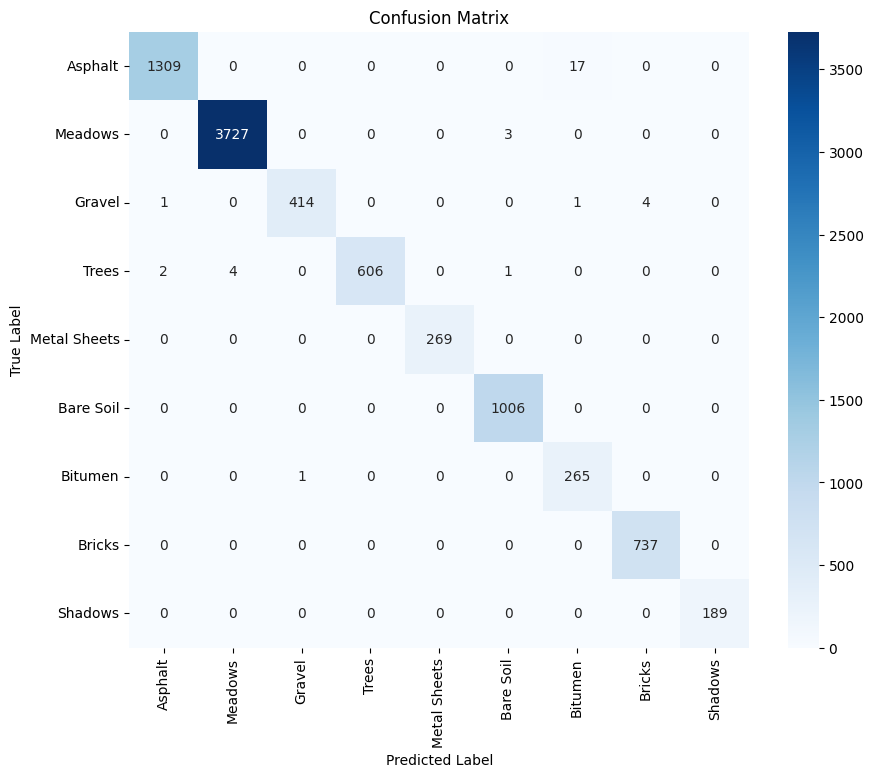

In [ ]:
# Cell 14: Evaluate on Test Set and Calculate Metrics

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model_on_test_set(model, data_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="Testing", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device) # Labels are already on CPU from dataloader, but good practice if they weren't

            outputs = model(inputs)
            loss = criterion(outputs, labels.to(device)) # Ensure labels on same device as outputs for loss calc

            running_loss += loss.item() * inputs.size(0)
            _, predicted_classes = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy()) # Collect labels (move to CPU, convert to numpy)
            all_predictions.extend(predicted_classes.cpu().numpy()) # Collect predictions

    test_loss = running_loss / len(data_loader.dataset) # Use len(dataset) for exact average

    # Convert lists to numpy arrays for scikit-learn metrics
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    # Calculate metrics
    overall_accuracy = accuracy_score(all_labels, all_predictions)
    kappa = cohen_kappa_score(all_labels, all_predictions)

    print(f"\n--- Test Set Evaluation ---")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Overall Accuracy (OA): {overall_accuracy*100:.2f}%")
    print(f"Cohen's Kappa (Κ): {kappa:.4f}")

    # Per-class metrics (Precision, Recall, F1-score)
    # Define class names for Pavia University (0-8 after re-labeling)
    # Original GT: 1:Asphalt, 2:Meadows, 3:Gravel, 4:Trees, 5:Painted metal sheets, 6:Bare Soil, 7:Bitumen, 8:Self-Blocking Bricks, 9:Shadows
    # After label-1: 0:Asphalt, 1:Meadows, ..., 8:Shadows
    class_names = ['Asphalt', 'Meadows', 'Gravel', 'Trees', 'Metal Sheets',
                   'Bare Soil', 'Bitumen', 'Bricks', 'Shadows']

    report = classification_report(all_labels, all_predictions, target_names=class_names, digits=4, zero_division=0)
    print("\nClassification Report:")
    print(report)

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_df, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    return overall_accuracy, kappa, report, conf_matrix_df, all_labels, all_predictions


# Perform evaluation on the test set
# Ensure test_loader and criterion are defined, and model is loaded with best weights
oa_test, kappa_test, report_test, conf_matrix_test, test_true_labels, test_pred_labels = evaluate_model_on_test_set(model, test_loader, criterion, device)

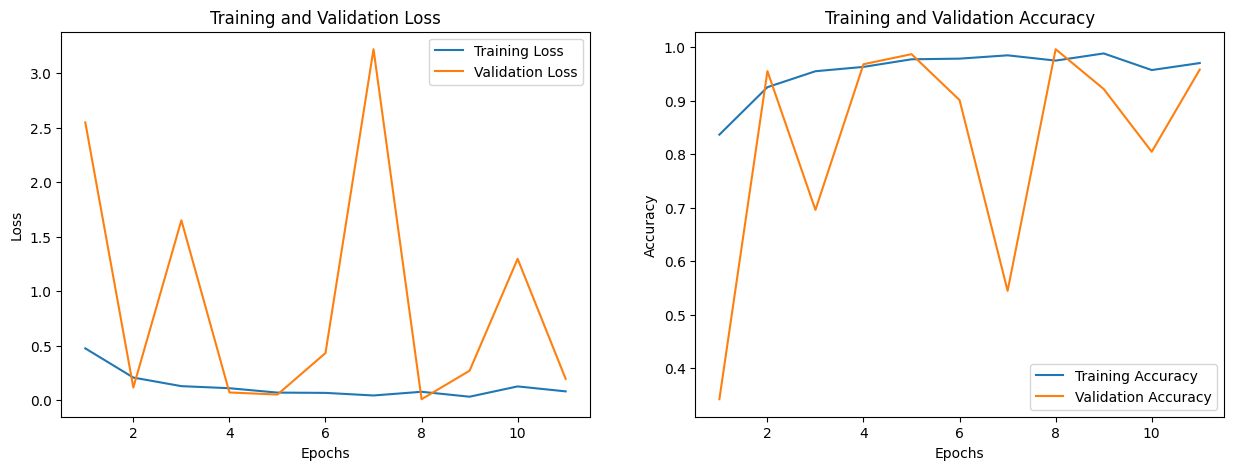

In [ ]:
# Cell 15: Plot Training History

epochs_range = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, label='Training Loss')
plt.plot(epochs_range, val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_history, label='Training Accuracy')
plt.plot(epochs_range, val_acc_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

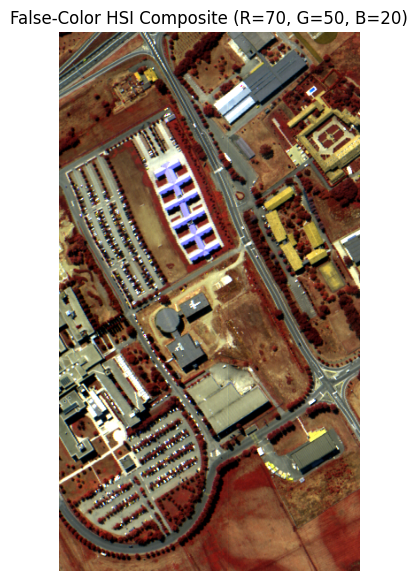

<ipython-input-18-d5eb2b55cb28>:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_gt = plt.cm.get_cmap('tab10', num_gt_classes)


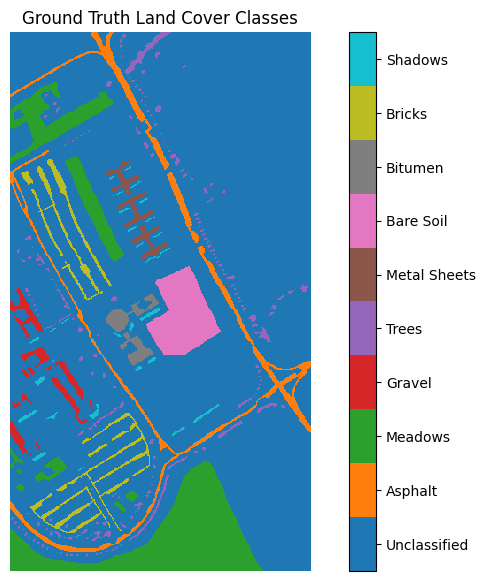

Cleaned up reloaded raw data for visualization.


In [ ]:
# Cell 16: Visualize HSI (False-Color) and Ground Truth Map

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import gc

try:
    _ = hsi_data_raw # Check if raw data exists
except NameError:
    print("Reloading hsi_data_raw for visualization...")
    # Ensure sio is imported if this cell is run independently
    import scipy.io as sio
    data_mat_viz = sio.loadmat(data_file_path) # data_file_path from Cell 1
    hsi_data_raw = data_mat_viz['paviaU']
    del data_mat_viz
    gc.collect()

try:
    _ = ground_truth_raw # Check if it exists
except NameError:
    print("Reloading ground_truth_raw for visualization...")
    import scipy.io as sio # Ensure sio is imported
    gt_mat_viz = sio.loadmat(gt_file_path) # gt_file_path from Cell 1
    ground_truth_raw = gt_mat_viz['paviaU_gt']
    del gt_mat_viz
    gc.collect()


# --- 1. False-Color Composite of HSI Data ---
# Select three bands for R, G, B channels.
band_R = 70
band_G = 50
band_B = 20

red_channel = hsi_data_raw[:, :, band_R].astype(np.float32)
green_channel = hsi_data_raw[:, :, band_G].astype(np.float32)
blue_channel = hsi_data_raw[:, :, band_B].astype(np.float32)

def normalize_band(band_data):
    p2, p98 = np.percentile(band_data, (2, 98))
    band_data_clipped = np.clip(band_data, p2, p98)
    # Handle case where min and max are the same after clipping (e.g., constant band)
    min_val = np.min(band_data_clipped)
    max_val = np.max(band_data_clipped)
    if max_val == min_val:
        return np.zeros_like(band_data_clipped) # or np.ones_like, or band_data_clipped itself
    return (band_data_clipped - min_val) / (max_val - min_val)


false_color_img = np.stack([
    normalize_band(red_channel),
    normalize_band(green_channel),
    normalize_band(blue_channel)
], axis=-1)

plt.figure(figsize=(10, 7))
plt.imshow(false_color_img)
plt.title(f'False-Color HSI Composite (R={band_R}, G={band_G}, B={band_B})')
plt.axis('off')
plt.show()

# --- 2. Ground Truth Map ---

# VVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVV
# DEFINE class_names HERE before using it
# These are the names for your 0-8 re-labeled classes
class_names = ['Asphalt', 'Meadows', 'Gravel', 'Trees', 'Metal Sheets',
               'Bare Soil', 'Bitumen', 'Bricks', 'Shadows']
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

num_gt_classes = int(np.max(ground_truth_raw)) + 1 # Should be 10 (0-9 for PaviaU original GT)
class_names_gt = ['Unclassified'] + class_names # Now class_names is defined

if num_gt_classes != len(class_names_gt):
    print(f"Warning: Mismatch between num_gt_classes ({num_gt_classes}) and length of class_names_gt ({len(class_names_gt)})")
    # Adjust class_names_gt if necessary, though for PaviaU it should be 10 and 1+9=10.
    # This might happen if ground_truth_raw unexpectedly has more/fewer unique values.
    # For PaviaU this is unlikely.

if num_gt_classes <= 10:
    cmap_gt = plt.cm.get_cmap('tab10', num_gt_classes)
elif num_gt_classes <= 20:
    cmap_gt = plt.cm.get_cmap('tab20', num_gt_classes)
else:
    colors = ['black', 'gray', 'red', 'green', 'blue', 'yellow', 'purple', 'cyan', 'magenta', 'orange',
              'brown', 'pink', 'lime', 'teal', 'lavender', 'turquoise', 'darkgreen', 'tan', 'salmon', 'gold', 'lightblue']
    if num_gt_classes > len(colors):
        for _ in range(num_gt_classes - len(colors)):
            colors.append(np.random.rand(3,))
    cmap_gt = mcolors.ListedColormap(colors[:num_gt_classes])


plt.figure(figsize=(10, 7))
plt.imshow(ground_truth_raw, cmap=cmap_gt, interpolation='nearest')
plt.title('Ground Truth Land Cover Classes')
plt.axis('off')

bounds = np.arange(-0.5, num_gt_classes, 1)
norm = mcolors.BoundaryNorm(bounds, cmap_gt.N)
tick_positions = np.arange(0, num_gt_classes, 1)

# Ensure we have enough labels for the colorbar
effective_class_names_for_cbar = class_names_gt[:num_gt_classes]

cbar = plt.colorbar(ticks=tick_positions, norm=norm, cmap=cmap_gt, boundaries=bounds, spacing='proportional')
cbar.ax.set_yticklabels(effective_class_names_for_cbar)
plt.show()

# Clean up reloaded raw data
try:
    del hsi_data_raw
    del ground_truth_raw
    gc.collect()
    print("Cleaned up reloaded raw data for visualization.")
except NameError:
    pass

In [ ]:
# Cell 17: Grad-CAM Implementation for 3D HSI CNN

import cv2 # For resizing/upsampling the heatmap

class GradCAM3D:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer # This will be the actual layer object, e.g., model.relu3_a
        self.feature_maps = None
        self.gradients = None

        # Register hooks
        self.target_layer.register_forward_hook(self._save_feature_maps)
        # We need the gradient of the output of the target layer
        # For nn.ReLU, its output is the same as its input if positive, so hooking its input (the conv layer's output)
        # or its output directly for gradients should be fine.
        # Hooking the module itself means we get gradients w.r.t. the output of this module.
        self.target_layer.register_full_backward_hook(self._save_gradients) # PyTorch 1.8+
        # For older PyTorch versions, you might need register_backward_hook on the tensor from target_layer.output

    def _save_feature_maps(self, module, input, output):
        self.feature_maps = output.detach() # Shape: (1, C_feat, D_feat, H_feat, W_feat)

    def _save_gradients(self, module, grad_input, grad_output):
        # grad_output is a tuple, we need the first element
        self.gradients = grad_output[0].detach() # Shape: (1, C_feat, D_feat, H_feat, W_feat)

    def __call__(self, input_tensor, target_class_idx=None):
        """
        Args:
            input_tensor (torch.Tensor): Input HSI patch, shape (1, 1, N_BANDS, H, W)
            target_class_idx (int, optional): Index of the target class.
                                             If None, uses the predicted class.
        Returns:
            heatmap (np.ndarray): 3D Grad-CAM heatmap, shape (N_BANDS, H, W)
        """
        self.model.eval() # Ensure model is in eval mode
        input_tensor = input_tensor.to(device)

        # Forward pass
        output_scores = self.model(input_tensor) # Shape: (1, N_CLASSES)

        if target_class_idx is None:
            target_class_idx = torch.argmax(output_scores, dim=1).item()

        # Target for backpropagation
        one_hot_output = torch.zeros_like(output_scores)
        one_hot_output[0][target_class_idx] = 1

        # Zero gradients
        self.model.zero_grad()

        # Backward pass to get gradients
        output_scores.backward(gradient=one_hot_output, retain_graph=True) # Pass one_hot to target specific class

        if self.gradients is None or self.feature_maps is None:
            raise ValueError("Gradients or feature maps not captured. Check hooks and target layer.")

        # Global Average Pooling of gradients to get neuron importance weights
        # Gradients shape: (1, C_feat, D_feat, H_feat, W_feat)
        weights = torch.mean(self.gradients, dim=(2, 3, 4), keepdim=True)
        # weights shape: (1, C_feat, 1, 1, 1)

        # Weighted combination of feature maps
        # feature_maps shape: (1, C_feat, D_feat, H_feat, W_feat)
        cam = torch.sum(weights * self.feature_maps, dim=1, keepdim=True)
        # cam shape: (1, 1, D_feat, H_feat, W_feat)

        # Apply ReLU
        cam = F.relu(cam)

        # Reshape to (D_feat, H_feat, W_feat) and move to CPU
        cam = cam.squeeze().cpu().numpy() # (D_feat, H_feat, W_feat)

        # Upsample the heatmap to the original input patch's D, H, W dimensions
        # Original input patch depth (D_in) is N_BANDS
        # Original input patch H, W is INPUT_PATCH_SIZE

        # We need to upsample (D_feat, H_feat, W_feat) to (N_BANDS, INPUT_PATCH_SIZE, INPUT_PATCH_SIZE)
        # cv2.resize is primarily for 2D images. For 3D, we can resize slice by slice or use scipy.ndimage.zoom

        # For simplicity, let's resize H, W for each D slice, then interpolate D
        # Or, more simply, just resize H,W and show slices, or average over D_feat if D_feat is small.
        # If D_feat from target layer is significantly different from N_BANDS, direct upsampling is tricky.

        # Let's check the D_feat dimension from our target layer.
        # Target layer was model.relu3_a, output shape (N, 64, 103, 15, 15)
        # So, D_feat = 103, H_feat = 15, W_feat = 15. This is good! D_feat is N_BANDS.

        # No upsampling needed if target_layer output D,H,W matches input D,H,W (after removing C_in=1)
        # In our case, model.relu3_a outputs (N, 64, 103, 15, 15).
        # So, cam is (103, 15, 15) which matches (N_BANDS, INPUT_PATCH_SIZE, INPUT_PATCH_SIZE). Perfect!

        # Normalize the heatmap to 0-1 for visualization
        if np.max(cam) > 0: # Avoid division by zero if cam is all zeros
            cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
        else:
            cam = np.zeros_like(cam)

        return cam, target_class_idx


# --- Instantiate Grad-CAM ---
# Choose the target layer. For our Attentive3DCNN, model.relu3_a is a good candidate
# (output of the last conv block before the aggressive MaxPool3d and FC layers)
target_layer_for_gradcam = model.relu3_a # Accessing the layer from the instantiated model
grad_cam_explainer = GradCAM3D(model, target_layer_for_gradcam)

print("GradCAM3D class defined and explainer instantiated.")

GradCAM3D class defined and explainer instantiated.



--- Grad-CAM for Sample 0 ---
True Label: 1 (Meadows)
Predicted Label: 1 (Meadows)
3D Heatmap shape: (103, 15, 15)


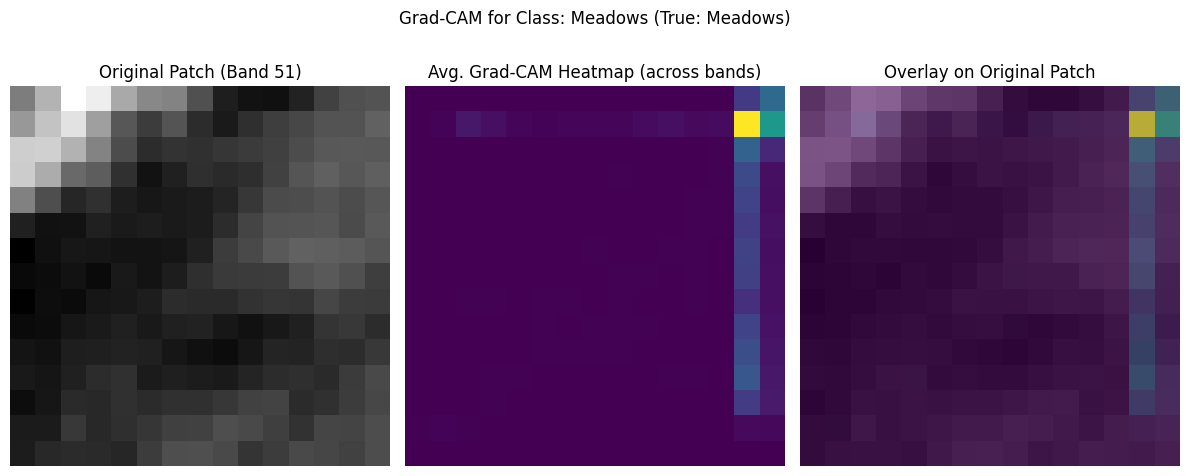

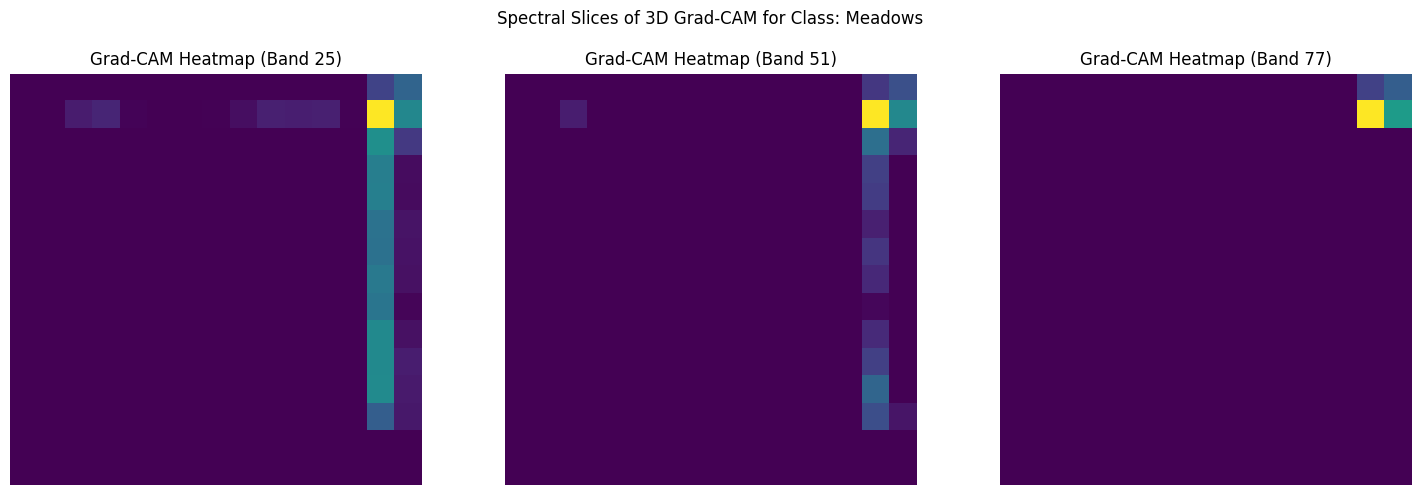

In [ ]:
# Cell 18: Generate and Visualize Grad-CAM for a Sample

# Pick a sample from the test set (or any set)
# Let's pick the first sample from the test_dataset
sample_idx = 0
input_patch_tensor, true_label_tensor = test_dataset[sample_idx]
input_patch_tensor = input_patch_tensor.unsqueeze(0) # Add batch dimension: (1, 1, N_BANDS, H, W)
true_label = true_label_tensor.item()

# Generate Grad-CAM heatmap
# The explainer will use the predicted class if target_class_idx is None
heatmap_3d, predicted_class_idx = grad_cam_explainer(input_patch_tensor, target_class_idx=None) # Or specify true_label

print(f"\n--- Grad-CAM for Sample {sample_idx} ---")
print(f"True Label: {true_label} ({class_names[true_label]})") # class_names from Cell 16
print(f"Predicted Label: {predicted_class_idx} ({class_names[predicted_class_idx]})")
print(f"3D Heatmap shape: {heatmap_3d.shape}") # Expected: (N_BANDS, H, W) e.g., (103, 15, 15)

# Visualize the heatmap
# We can visualize:
# 1. A few spectral slices of the heatmap.
# 2. An average of the heatmap across the spectral dimension.
# 3. Overlay the (averaged) heatmap on one of the original patch's spectral bands.

# Get the original patch data (for overlay)
# input_patch_tensor is (1, 1, N_BANDS, H, W)
original_patch_for_viz = input_patch_tensor.squeeze().cpu().numpy() # (N_BANDS, H, W)

# --- Visualization Option 1: Average Heatmap across spectral dimension ---
avg_heatmap_2d = np.mean(heatmap_3d, axis=0) # (H, W)

plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
# Display a representative band of the original patch (e.g., middle band)
middle_band_idx = N_BANDS // 2
plt.imshow(original_patch_for_viz[middle_band_idx, :, :], cmap='gray')
plt.title(f'Original Patch (Band {middle_band_idx})')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(avg_heatmap_2d, cmap='viridis') # 'viridis' or 'hot' are good for heatmaps
plt.title('Avg. Grad-CAM Heatmap (across bands)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(original_patch_for_viz[middle_band_idx, :, :], cmap='gray')
plt.imshow(avg_heatmap_2d, cmap='viridis', alpha=0.6) # Overlay with transparency
plt.title('Overlay on Original Patch')
plt.axis('off')
plt.suptitle(f'Grad-CAM for Class: {class_names[predicted_class_idx]} (True: {class_names[true_label]})')
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
plt.show()


# --- Visualization Option 2: Show specific spectral slices of the 3D heatmap ---
# Choose a few band indices from the heatmap to display
heatmap_band_indices_to_show = [N_BANDS // 4, N_BANDS // 2, 3 * N_BANDS // 4] # Example indices

plt.figure(figsize=(15, 5))
for i, band_idx in enumerate(heatmap_band_indices_to_show):
    plt.subplot(1, len(heatmap_band_indices_to_show), i + 1)
    plt.imshow(heatmap_3d[band_idx, :, :], cmap='viridis')
    plt.title(f'Grad-CAM Heatmap (Band {band_idx})')
    plt.axis('off')
plt.suptitle(f'Spectral Slices of 3D Grad-CAM for Class: {class_names[predicted_class_idx]}')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()